# 【自前AI講座】ディープラーニング基礎と実装

---

In [1]:
import numpy as np
import tensorflow as tf
from keras import layers, optimizers, metrics, losses, Model, callbacks

# データセット準備
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(x_train.dtype, y_train.dtype, x_test.dtype, y_test.dtype)

# 画素値を 0～255 から 0～1 に正規化
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# クラス数を算出
classes = len(set(y_train))

# モデル定義
inputs = layers.Input(shape=x_train.shape[1:])
x = inputs
x = layers.Flatten()(x)
x = layers.Dense(units=32)(x)
x = layers.ReLU()(x)
x = layers.Dense(units=32)(x)
x = layers.ReLU()(x)
x = layers.Dense(units=32)(x)
x = layers.ReLU()(x)
x = layers.Dense(units=32)(x)
x = layers.ReLU()(x)
x = layers.Dense(units=classes)(x)
x = layers.Softmax()(x)
outputs = x
model = Model(inputs=inputs, outputs=outputs)
# 最適化関数，損失関数，評価関数の定義
model.compile(
    optimizer=optimizers.SGD(learning_rate=0.01),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

# 学習
model.fit(x=x_train, y=y_train, batch_size=32, epochs=5)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
uint8 uint8 uint8 uint8
Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9161 - sparse_categorical_accuracy: 0.7151
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3297 - sparse_categorical_accuracy: 0.9017
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2621 - sparse_categorical_accuracy: 0.9222
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2190 - sparse_categorical_accuracy: 0.9354
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1883 - sparse_categorical_accuracy: 0.9444


In [2]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

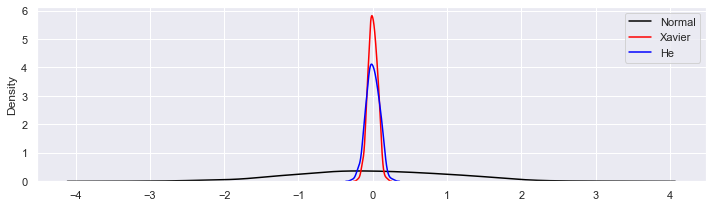

In [3]:
neuron_num = 256
rng = np.random.default_rng(seed=0)
rng_normal = rng.normal(size=neuron_num)
rng_xavier = rng_normal * math.sqrt(1 / neuron_num)
rng_he = rng_normal * math.sqrt(2 / neuron_num)

plt.figure(figsize=(10, 3), facecolor="white")
sns.kdeplot(rng_normal, color="black", label="Normal")
sns.kdeplot(rng_xavier, color="red", label="Xavier")
sns.kdeplot(rng_he, color="blue", label="He")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

### バッチ正規化

$$
\hat{x_i} \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$

$$
y_i \leftarrow \gamma \hat{x_i} + \beta
$$

## 最適化関数

$$
\theta_t \leftarrow \theta_{t-1} - \eta \frac{\hat{m_t}}{\sqrt{\hat{\nu_t}} + \epsilon}
$$

$$
\hat{m_t} \leftarrow \frac{m_t}{1 - \beta_1^{(t)}} \\
\hat{\nu_t} \leftarrow \frac{\nu_t}{1 - \beta_2^{(t)}} \\
m_t \leftarrow \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
\nu_t \leftarrow \beta_2 \nu_{t-1} + (1 - \beta_2) g_t^2
$$

## 乱数シード値の固定

In [4]:
import gc
import os
import random

In [5]:
def seed_everything(seed: int = 0):
    # os
    os.environ["PYTHONHASHSEED"] = str(seed)
    # random
    random.seed(seed)
    # numpy
    np.random.seed(seed)
    # tensorflow
    tf.random.set_seed(seed)
    # for GPU : https://github.com/NVIDIA/framework-determinism
    os.environ["TF_DETERMINISTIC_OPS"] = "true"
    os.environ["TF_CUDNN_DETERMINISTIC"] = "true"


seed_everything()

## 演習問題

Q. mnist を次に指定するニューラルネットワーク構造，及び，学習方法にて学習してください．

- 隠れ層４つの全結合層で，活性化関数は ReLU （各層のニューロン数の設定は自由）
- バッチ正規化と drop out を入れる（削除割合の設定は自由）
- 重みの初期化については，ReLU の場合は He の初期値，Softmax の場合は Xavier の初期値を用いる
- 学習 epoch は 30 で，学習率を上限 0.01 とした warm up が 3 の cosine decay とする
- 評価用データの結果も毎 epoch 計算させる

## 演習問題の解答

In [6]:
warm_up_epoch = 3
max_lr = 0.01
final_epoch = 30


def lr_scheduler(epoch: int, _: float) -> float:
    if epoch <= warm_up_epoch:
        scheduled_lr = epoch / warm_up_epoch * max_lr
    else:
        scheduled_lr = (
            (
                math.cos(
                    (epoch - warm_up_epoch) / (final_epoch - warm_up_epoch) * math.pi
                )
                + 1
            )
            * max_lr
            / 2
        )
    scheduled_lr = round(scheduled_lr, ndigits=9)
    return scheduled_lr

In [7]:
tf.keras.backend.clear_session()
gc.collect()

inputs = layers.Input(shape=x_train.shape[1:])

x = inputs
x = layers.Flatten()(x)
for i in range(4):
    x = layers.Dense(units=128, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(rate=0.2)(x)
x = layers.Dense(units=classes, kernel_initializer="glorot_uniform")(x)
x = layers.Softmax()(x)
outputs = x

model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model.summary()

model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    batch_size=32,
    epochs=30,
    callbacks=[
        callbacks.ModelCheckpoint(
            filepath="./model.h5",
            monitor="val_loss",
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode="auto",
            save_freq="epoch",
        ),
        callbacks.LearningRateScheduler(
            schedule=lr_scheduler,
            verbose=0,
        ),
    ],
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             